In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
%matplotlib inline

## Data manipulation

In [2]:
# Import cancellations and bookings datasets

cancellations = pd.read_csv('Client_Cancellations.csv')
bookings = pd.read_csv('Future_Bookings_All_Clients.csv')

In [4]:
# Concatenate datasets into one

bookings = bookings.rename(columns={'Date': 'Booking Date'})
all_bookings = pd.concat([cancellations, bookings])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [5]:
# Rename columns for ease of manipulation

all_bookings = all_bookings.reset_index(drop=True)
column_names = all_bookings.columns
column_names = ['booking_date', 'cancel_date', 'canceled_by', 'code', 'days', 'service', 'staff', 'time', 'time_int']
all_bookings.columns = column_names

In [6]:
# Change dates to date type rather than string

all_bookings.loc[:,['booking_date', 'cancel_date']] = all_bookings.loc[:,['booking_date', 'cancel_date']].apply(lambda x: pd.to_datetime(x, format='%m/%d/%Y'))

In [8]:
# Include an indicator of whether canceled and sort by booking date

all_bookings['canceled'] = (all_bookings.cancel_date.isnull() == False)
all_bookings.sort_values('booking_date', inplace=True)
all_bookings = all_bookings.reset_index(drop=True)

In [9]:
# Slice out dates for April, May and June only (Q2)
# These months were included in both original datasets
# This means we can compare attended vs canceled

bookings_q2 = all_bookings.loc[(all_bookings.booking_date > '2018-03-31') & (all_bookings.booking_date < '2018-07-01'),]
bookings_q2.reset_index(drop=True, inplace=True)
bookings_q2.head()

,booking_date,cancel_date,canceled_by,code,days,service,staff,time,time_int,canceled
0,2018-04-01,NaT,NaN,SLEA01,NaN,CON,HOUSE,11:10:00 AM,670.0,False
1,2018-04-03,NaT,NaN,LINJ01,NaN,SHCW,JJ,10:00:00 AM,600.0,False
2,2018-04-03,NaT,NaN,THOW01,NaN,SBD,JJ,9:00:00 AM,540.0,False
3,2018-04-03,2018-05-10,JJ,KOOM01,-37.0,SHCW,JJ,NaN,NaN,True
4,2018-04-03,NaT,NaN,YATT01,NaN,SHCM,BECKY,11:00:00 AM,660.0,False


## Exploratory analysis

#### Look at the proportion of appointments that are canceled.

In [11]:
canceled_counts = bookings_q2.canceled.value_counts().to_frame()
canceled_counts['type'] = ['Attended', 'Canceled']
canceled_counts

,canceled,type
False,1229,Attended
True,148,Canceled


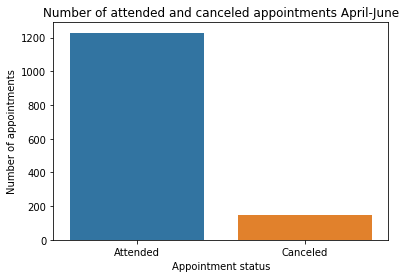

In [25]:
g = sns.barplot(x='type', y='canceled', data=canceled_counts)
g.set_xlabel('Appointment status')
g.set_ylabel('Number of appointments')
g.set_title('Number of attended and canceled appointments April-June')
plt.show()

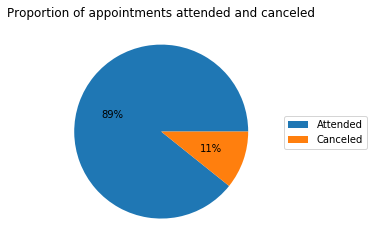

In [32]:
plt.pie(x=canceled_counts.canceled,
        autopct='%.0f%%')
plt.legend(['Attended', 'Canceled'], loc = 'right', bbox_to_anchor=(1, 0.5), bbox_transform=plt.gcf().transFigure)
plt.title('Proportion of appointments attended and canceled')
plt.show()

#### Look at whether there is a trend in cancellations over time.

In [33]:
q2_cancel_by_date = bookings_q2.groupby('booking_date')['canceled'].agg('sum').to_frame()
q2_cancel_by_date.reset_index(inplace=True)
q2_booking_by_date = bookings_q2.booking_date.value_counts().to_frame()
q2_booking_by_date.reset_index(inplace=True)
q2_booking_by_date.columns = ['booking_date', 'appointments']
q2_booking_by_date.sort_values('booking_date', inplace=True)
q2_booking_counts = pd.merge(q2_cancel_by_date, q2_booking_by_date, on='booking_date')
q2_booking_counts.sort_values('booking_date', inplace=True)
q2_booking_counts.head()

,booking_date,canceled,appointments
0,2018-04-01,0.0,1
1,2018-04-03,2.0,12
2,2018-04-04,2.0,12
3,2018-04-05,0.0,16
4,2018-04-06,0.0,16


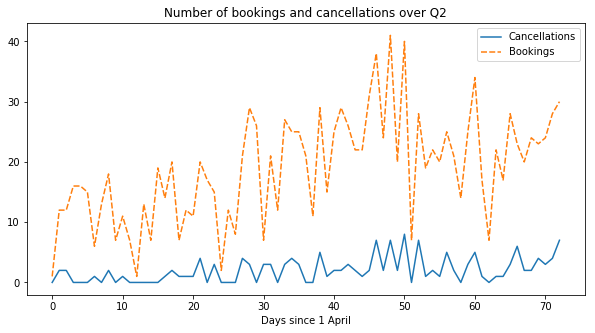

In [37]:
fig, ax = plt.subplots(figsize=(10, 5))
g = sns.lineplot(data = [q2_booking_counts.canceled, q2_booking_counts.appointments])
g.set_ylabel('')
g.set_xlabel('Days since 1 April')
g.legend(['Cancellations', 'Bookings'])
g.set_title('Number of bookings and cancellations over Q2')
plt.show()

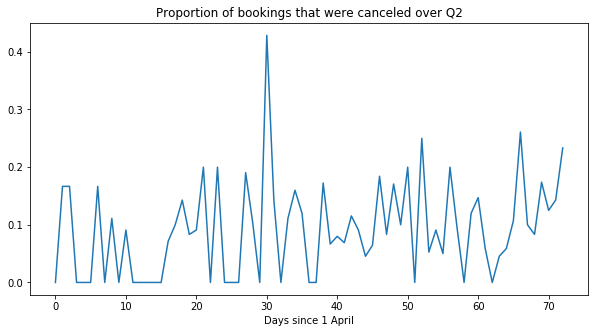

In [40]:
q2_booking_counts['proportion'] = q2_booking_counts['canceled'] / q2_booking_counts['appointments']

plt.figure(figsize=(10, 5))
g = sns.lineplot(data=[q2_booking_counts.proportion], legend=False)
g.set_xlabel('Days since 1 April')
g.set_ylabel('')
g.set_title('Proportion of bookings that were canceled over Q2')
plt.show()

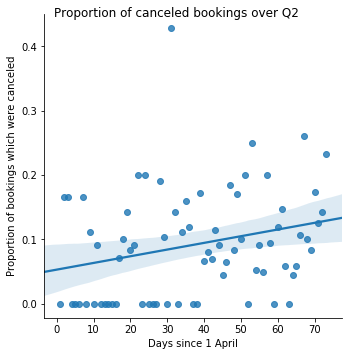

In [49]:
q2_booking_counts['day'] = (q2_booking_counts.index +1)

g = sns.lmplot(x='day', y='proportion', data=q2_booking_counts)
g.set_axis_labels('Days since 1 April', 'Proportion of bookings which were canceled')
g.fig.suptitle('Proportion of canceled bookings over Q2')
plt.show()

#### Look at whether it varies by appointment type.

In [50]:
service_total_cancel = bookings_q2.groupby('service').aggregate(sum)
service_total_cancel = service_total_cancel.reset_index()

In [51]:
service_count = bookings_q2.service.value_counts().to_frame()
service_count = service_count.reset_index()
service_count.columns = ['service', 'count']

In [54]:
q2_service = pd.merge(service_total_cancel, service_count, left_on='service', right_on='service')
q2_service['prop_canceled'] = q2_service['canceled'] / q2_service['count']
q2_service['attended'] = q2_service['count'] - q2_service['canceled']
q2_service.head()

,service,days,time_int,canceled,count,prop_canceled,attended
0,CAL,0.0,720.0,0.0,1,0.000000,1.0
1,CALC,0.0,16520.0,0.0,22,0.000000,22.0
2,CAS,0.0,840.0,0.0,1,0.000000,1.0
3,CBAL,6.0,7910.0,7.0,17,0.411765,10.0
4,CCAMO,4.0,7000.0,3.0,12,0.250000,9.0


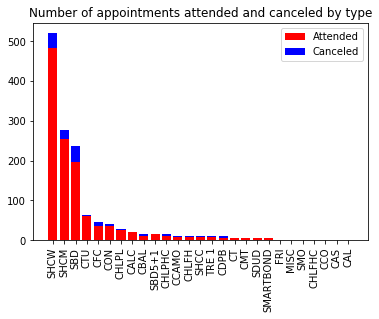

In [70]:
q2_service.sort_values('count', inplace=True, ascending=False)
p1 = plt.bar(x=q2_service['service'], height=(q2_service['count'] - q2_service['canceled']), color='red')
p2 = plt.bar(x='service', height='canceled', color='blue', data=q2_service, bottom=(q2_service['count'] - q2_service['canceled']))
plt.xticks(rotation='vertical')
plt.title('Number of appointments attended and canceled by type')
plt.legend(['Attended', 'Canceled'])
plt.show()

In [57]:
top3_services = ['SHCW', 'SHCM', 'SBD']
q2_service_top3 = q2_service[q2_service.service.isin(top3_services)]
q2_service_nottop3 = q2_service[~q2_service.service.isin(top3_services)]

In [86]:
count_top3 = len(bookings_q2[bookings_q2.service.isin(top3_services)])
count_nottop3 = len(bookings_q2[~bookings_q2.service.isin(top3_services)])
count_top3 / (count_top3 + count_nottop3)

0.7501815541031227

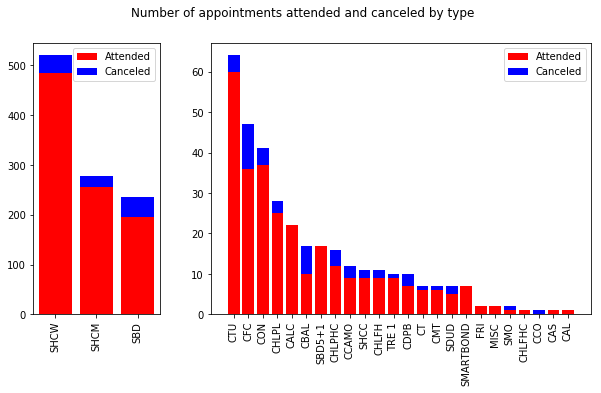

In [73]:
# Zoom in to see less popular services more clearly.

fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(1, 2, width_ratios = [1, 3])

ax0 = plt.subplot(gs[0])
p1 = plt.bar(x=q2_service_top3['service'], height=q2_service_top3['attended'], color='red')
p2 = plt.bar(x=q2_service_top3['service'], height=q2_service_top3['canceled'], color='blue', bottom=(q2_service_top3['attended']))
plt.legend(['Attended', 'Canceled'])
plt.xticks(rotation='vertical')

ax1 = plt.subplot(gs[1])
p1 = plt.bar(x=q2_service_nottop3['service'], height=q2_service_nottop3['attended'], color='red')
p2 = plt.bar(x=q2_service_nottop3['service'], height=q2_service_nottop3['canceled'], color='blue', bottom=(q2_service_nottop3['attended']))
plt.legend(['Attended', 'Canceled'])
plt.xticks(rotation='vertical')

plt.suptitle('Number of appointments attended and canceled by type')
plt.show()

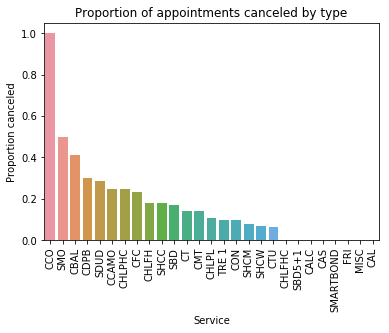

In [76]:
q2_service.sort_values('prop_canceled', inplace=True, ascending=False)
g = sns.barplot(x='service', y='prop_canceled', data=q2_service)
g.set_ylabel('Proportion canceled')
g.set_xlabel('Service')
g.set_title('Proportion of appointments canceled by type')
plt.xticks(rotation='vertical')
plt.show()

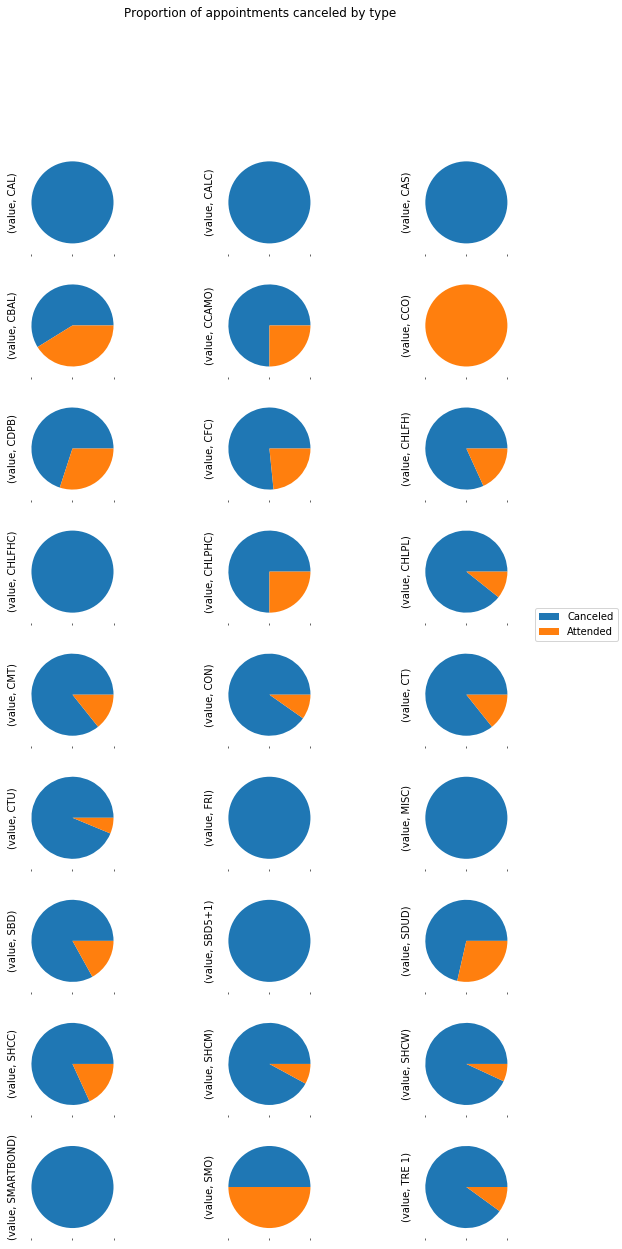

In [78]:
q2_service_long = pd.melt(q2_service, id_vars=['service'], value_vars=['canceled', 'attended'], var_name = 'status')
q2_service_long_grouped = q2_service_long.groupby(['status', 'service']).agg('sum').unstack(1)

q2_service_long_grouped.plot(kind='pie', subplots=True, 
          layout=(9, 3), legend=False, figsize=(10, 20),
          labels=None)
plt.figlegend(labels=['Canceled', 'Attended'], loc='center right')
plt.suptitle('Proportion of appointments canceled by type')
plt.show()

#### Look at the notice given when canceling appointments

In [79]:
q2_notice = bookings_q2.days.value_counts().to_frame()
q2_notice.reset_index(inplace=True)
q2_notice.columns = ['days_notice', 'count']
q2_notice.sort_values('days_notice', inplace=True)
q2_notice = q2_notice[q2_notice.days_notice >= 0]
q2_notice.days_notice = q2_notice.days_notice.astype(int)
q2_notice.head()

,days_notice,count
0,0,47
1,1,26
2,2,14
4,3,9
5,4,7


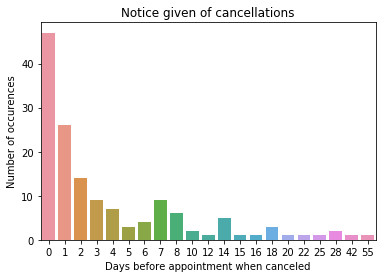

In [80]:
g = sns.barplot(x='days_notice', y='count', data=q2_notice)
g.set_xlabel("Days before appointment when canceled")
g.set_ylabel('Number of occurences')
g.set_title('Notice given of cancellations')
plt.show()

## Research Proposal

### Analysis

The hair salon data shows that around 11% of appointments end up being canceled. The most common day to cancel an appointment is on the same day, and the next two most common days to cancel are the two days before the appointment.

Cancellations appear to be getting more common over the three months considered in this dataset. This is true as an absolute amount of cancellations and as a proportion of total bookings.

There is some variability in terms of which services are most likely to get canceled. However, the top three services, which account for 75% of bookings, have a similar cancellation rate.

### The problem

How can we decrease cancellations? Cancellations create inefficiency as hair salon staff are not working, fees for appointments may not be paid and clients who would have taken the appointments are denied service. The majority of cancellations are made in either on the day of the appointment, or in the days leading up to the appointment. This suggests that people might forget they have an appointment and make alternative plans, leading to a last minute cancellation.

### The potential solution

Sending customers a reminder via text 3 days before their appointment will decrease cancellations.

### Experiment plan

Send half of all customers a reminder via text 3 days before their appointment and monitor cancellations for the next three months. The variable of interest is number of cancellations in reminded and non-reminded groups of customers for three months during the study. This is an A/B manipulation where customers are reminded or not reminded.

### Implementing the experiment

At the time of booking, each customer is allocated to either the 'reminded' or 'not reminded' group. This is done by flipping a coin.

A text reminder system is set up so that customers in the 'reminded' group are automatically sent an appointment reminder 3 days before their appointment.

If a customer books an appointment within 3 days of the appointment date consider them part of the 'reminded' group, but note that a text was not sent as another variable.

### Outcomes and variables of interest

The key metric is whether or not a customer cancels their appointment. Other variables to be recorded should be:

- Date booking was made
- Date of appointment
- Date of cancellation (to calculate days before booking)
- Reason for cancellation (if possible)
- Whether the appointment slot was filled by another customer

### Evaluating the experiment

We will compare the level of cancellations during the study to three months before the study. If cancellations decrease by one standard deviation or more among reminded customers then we can conclude that reminding customers is effective. If cancellations decrease, but by less than one standard deviation, observe for another three months and then decide. If cancellations do not decrease but notification happens earlier, then rerun the experiment reminding customers 7 days in advance. If there is no decrease in cancellations and no change in timing, conclude that reminders are ineffective.